In [1]:
import numpy as np
import pandas as pd
from gensim.models import KeyedVectors

from collections import Counter, defaultdict
from functools import reduce
import random
import re
import gc
from tqdm.auto import tqdm
import time
import random
import string

import torch
import torch.utils.data
import torch.nn as nn
import torch.tensor as tensor
import torch.autograd as autograd
from torch.autograd import Variable

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import GridSearchCV, StratifiedKFold

import scipy.stats
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from torchsummary import summary

tqdm.pandas()

Using TensorFlow backend.


## Load dataset

In [3]:
DATA_DIR = "../input"
TRAIN_CSV = f"{DATA_DIR}/train.csv"
TEST_CSV = f"{DATA_DIR}/test.csv"

train_df = pd.read_csv(TRAIN_CSV)
test_df = pd.read_csv(TEST_CSV)

print(f"Train shape: {train_df.shape}; cols: {list(train_df.columns)}")
print(f"Test shape: {test_df.shape}; cols: {list(test_df.columns)}")

Train shape: (1306122, 3); cols: ['qid', 'question_text', 'target']
Test shape: (375806, 2); cols: ['qid', 'question_text']


In [4]:
sincere = train_df.loc[train_df['target'] == 0]
insincere = train_df.loc[train_df['target'] == 1]

print(
    f"sincere: {len(sincere)} ({round(100.0 * len(sincere)/len(train_df), 3)}%); "
    f"insincere: {len(insincere)} ({round(100.0 * len(insincere)/len(train_df), 3)}%); "
    f"ratio (-/+): {round(len(sincere)/len(insincere), 3)}; "
    f"ratio (+/-): {round(len(insincere)/len(sincere), 3)}\n"
)

print(
    f"sincere: {sincere.iloc[random.randint(0, len(sincere))]['question_text']}\n\n"
    f"insincere: {insincere.iloc[random.randint(0, len(insincere))]['question_text']}"
)
print()

sincere: 1225312 (93.813%); insincere: 80810 (6.187%); ratio (-/+): 15.163; ratio (+/-): 0.066

sincere: Is Islam a good thing?

insincere: What is the point of letting criminals that committed felonies back to the society? Why can't we simply lock them up like nuclear waste?



## Load embeddings

In [5]:
EMB_GLOVE_FILE = f"{DATA_DIR}/embeddings/glove.840B.300d/glove.840B.300d.txt"
EMB_WORD2VEC_FILE = f"{DATA_DIR}/embeddings/GoogleNews-vectors-negative300/GoogleNews-vectors-negative300.bin"
EMB_PARAGRAM_FILE = f"{DATA_DIR}/embeddings/paragram_300_sl999/paragram_300_sl999.txt"
EMB_WIKI_FILE = f"{DATA_DIR}/embeddings/wiki-news-300d-1M/wiki-news-300d-1M.vec"

### word2vec

In [89]:
emb_word2vec = KeyedVectors.load_word2vec_format(EMB_WORD2VEC_FILE, binary=True)

In [1]:
print(f"{len(emb_word2vec.vocab)} x {emb_word2vec['the'].size}")
print("xiaomi" in emb_word2vec)

NameError: name 'emb_word2vec' is not defined

### Wiki

In [105]:
def load_wiki():
    def get_coefs(word,*arr): 
        return word, np.asarray(arr, dtype='float32')
    
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMB_WIKI_FILE) if len(o)>100)
    
    return embeddings_index

emb_wiki = load_wiki()

In [106]:
print(f"{len(emb_wiki)} x {emb_wiki['the'].size}")
print("xiaomi" in emb_wiki)

999994 x 300
False


### GloVe

In [6]:
def load_glove():
    def get_coefs(word,*arr): 
        return word, np.asarray(arr, dtype='float32')
    
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMB_GLOVE_FILE, encoding='latin'))
        
    return embeddings_index

emb_glove = load_glove()

In [7]:
print(f"{len(emb_glove)} x {emb_glove['a'].size}")
print("xiaomi" in emb_glove)

2196016 x 300
True


### ParaGram

In [8]:
def load_paragram():
    def get_coefs(word,*arr): 
        return word, np.asarray(arr, dtype='float32')
    
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMB_PARAGRAM_FILE, encoding="utf8", errors='ignore') if len(o)>100)

    return embeddings_index
    
emb_paragram = load_paragram()

In [13]:
print(f"{len(emb_paragram)} x {emb_paragram['the'].size}")
print("paytm" in emb_paragram)

1703755 x 300
True


## Combine embeddings

In [14]:
def combine_emb_dicts(*embs):
    out_emb = defaultdict(lambda : np.zeros(300, dtype=np.float32))
    
    n = len(embs)
    
    for emb in tqdm(embs, total=n):
        for w, e in tqdm(emb.items()):
            out_emb[w] += (1.0/n) * e
                
    return out_emb
            

emb_glove_paragram = combine_emb_dicts(emb_glove, emb_paragram)

## Embeddings testing

In [9]:
_glove_not_w2v = Counter()
_w2v_not_glove = Counter()

for w in tqdm(emb_word2vec.vocab):
    if w not in emb_glove:
        _w2v_not_glove[w] += 1

for w in tqdm(emb_glove):
    if w not in emb_word2vec:
        _glove_not_w2v[w] += 1

NameError: name 'emb_word2vec' is not defined

In [ ]:
print(f"glove not w2v: {len(_glove_not_w2v)}; w2v not glove: {len(_w2v_not_glove)}")
print("-" * 64)
print(random.sample(set(_w2v_not_glove), 10))
print("-" * 64)
print(random.sample(set(_glove_not_w2v), 10))

## Clean dataset

In [22]:
PUNCTUATION = {
    'sep'   : u'\u200b' + "/-'´′‘…—−–",
    'keep'  : "&",
    'remove': '?!.,，"#$%\'()*+-/:;<=>@[\\]^_`{|}~“”’™•°'
}

SYN_DICT = {
    'cryptocurrencies': 'crypto currencies',
    'ethereum'        : 'crypto currency',
    'coinbase'        : 'crypto platform',
    'altcoin'         : 'crypto currency',
    'altcoins'        : 'crypto currency',
    'litecoin'        : 'crypto currency',
    'fortnite'        : 'video game',
    'quorans'         : 'quora members',
    'quoras'          : 'quora members',
    'qoura'           : 'quora',
    'brexit'          : 'britain exit',
    'redmi'           : 'phone',
    'oneplus'         : 'phone',
    'hackerrank'      : 'programming challenges',
    'bhakts'          : 'gullible',
    '√'               : 'square root',
    '÷'               : 'division',
    '∞'               : 'infinity',
    '€'               : 'euro',
    '£'               : 'pound sterling',
    '$'               : 'dollar',
    '₹'               : 'rupee',
    '×'               : 'product',
    'ã'               : 'a',
    'è'               : 'e',
    'é'               : 'e',
    'ö'               : 'o',
    '²'               : 'squared',
    '∈'               : 'in',
    '∩'               : 'intersection',
    u'\u0398'         : 'Theta',
    u'\u03A0'         : 'Pi',
    u'\u03A9'         : 'Omega',
    u'\u0392'         : 'Beta',
    u'\u03B8'         : 'theta',
    u'\u03C0'         : 'pi',
    u'\u03C9'         : 'omega',
    u'\u03B2'         : 'beta',
}


def tokenize(s: str):
    return list(map(lambda w: w.strip(), s.split()))


def clean_text(x):
    x = x.lower()

    for p in PUNCTUATION['sep']:
        x = x.replace(p, " ")
    for p in PUNCTUATION['keep']:
        x = x.replace(p, f" {p} ")
    for p in PUNCTUATION['remove']:
        x = x.replace(p, "")

    return x


def clean_numbers(x):
    x = re.sub('[0-9]{5,}', '#####', x)
    x = re.sub('[0-9]{4}', '####', x)
    x = re.sub('[0-9]{3}', '###', x)
    x = re.sub('[0-9]{2}', '##', x)

    return x


def clean_site(x):
    regex = re.compile('(www)([a-z0-9]+)(com|org)')
    return regex.sub(lambda m: m.group(2), x)


def clean_syn(x):
    regex = re.compile('(%s)' % '|'.join(SYN_DICT.keys()))
    return regex.sub(lambda m: SYN_DICT.get(m.group(0), ''), x)


def clean_all(x):
    x = clean_text(x)
    x = clean_syn(x)
    x = clean_site(x)
    return x
    

def build_vocabulary(df: pd.DataFrame) -> Counter:
    sentences = df.progress_apply(tokenize).values
    vocab = Counter()
    s_len = []
    
    for sentence in tqdm(sentences):  
        s_len.append(len(sentence))
        for word in sentence:
            vocab[word] += 1
    return vocab, np.array(s_len)

In [23]:
# clean
train_df["clean_question_text"] = train_df["question_text"].progress_apply(clean_all)
test_df["clean_question_text"] = test_df["question_text"].progress_apply(clean_all)

# vocab
train_vocab, train_s_len = build_vocabulary(train_df["clean_question_text"])
test_vocab, test_s_len = build_vocabulary(test_df["clean_question_text"])

train: DescribeResult(nobs=1306122, minmax=(0, 135), mean=12.985180557405817, variance=51.695601827754984, skewness=1.7884284249354365, kurtosis=4.158424002622946), median: 11.0
test: DescribeResult(nobs=375806, minmax=(1, 87), mean=12.992267286844807, variance=51.59525692509565, skewness=1.7865806901779087, kurtosis=4.114102674231951), median: 11.0


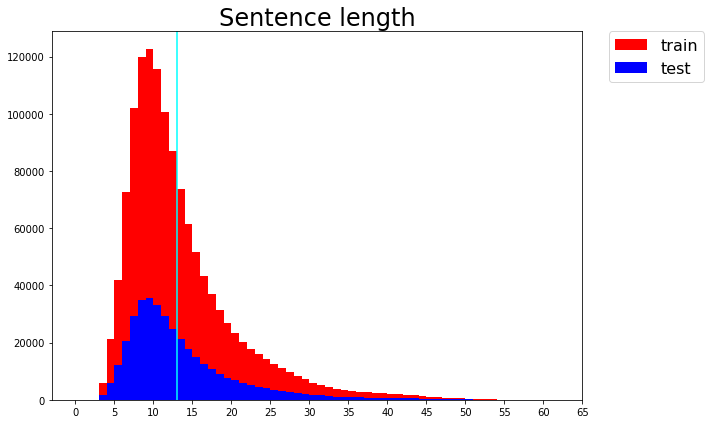

In [125]:
d_train = scipy.stats.describe(train_s_len)
d_test = scipy.stats.describe(test_s_len)
print(f"train: {d_train}, median: {np.median(train_s_len)}")
print(f"test: {d_test}, median: {np.median(test_s_len)}")

nb = 60

plt.figure(figsize=(10, 6))

plt.hist(train_s_len, bins=nb, range=[0, 60], facecolor='red', label='train')

plt.hist(test_s_len, bins=nb, range=[0, 60], facecolor='blue', label='test')
plt.axvline(x=d_test.mean, color='cyan')

plt.title("Sentence length", size=24)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., prop={'size': 16})
plt.xticks([5*i for i in range(14)])
plt.tight_layout()
plt.show()

## Most common words

In [ ]:
_n = 20
exclude = [
    "the", "of", "and", "to", "a", "in", "is", "i",
    "that", "it", "for", "you", "was", "with", "on",
    "as", "have", "but", "be", "they"
]

for w in exclude:
    del train_vocab[w]
    del test_vocab[w]
    
Tmc = train_vocab.most_common()
tmc = test_vocab.most_common()

for i in range(_n):
    print(f"{Tmc[i]} -- {tmc[i]}")

## Less common words

In [ ]:
n = 20
Tmc = train_vocab.most_common()[:-n-1:-1]
tmc = test_vocab.most_common()[:-n-1:-1]

u = 0
t = 10
for w in train_vocab:
    u += (train_vocab[w] <= t)
print(f"[train] {round(100.0 * u/len(train_vocab), 3)}% words have <= {t} occurences")
    
u = 0
t = 10
for w in test_vocab:
    u += (test_vocab[w] <= t)
print(f"[test]  {round(100.0 * u/len(train_vocab), 3)}% words have <= {t} occurences")

print()
    
for i in range(n):
    print(f"{Tmc[i]} -- {tmc[i]}")

In [ ]:
test_not_in_train = Counter()
train_not_in_test = Counter()

for w in test_vocab:
    if w not in train_vocab:
        test_not_in_train[w] += 1

for w in train_vocab:
    if w not in test_vocab:
        train_not_in_test[w] += 1
        
train_uniq_words = set(train_vocab.keys())
test_uniq_words = set(test_vocab.keys())
uniq_words = set(train_uniq_words.union(test_uniq_words))
all_oov = Counter()

for w in uniq_words:
    if w not in emb_glove:
        all_oov[w] += 1
        
print(f"train not in test: {len(train_not_in_test)}")
print(f"test not in train: {len(test_not_in_train)}")
print(f"train uniq: {len(train_uniq_words)}")
print(f"test uniq: {len(test_uniq_words)}")
print(f"total uniq words: {len(uniq_words)}")

# all_oov.most_common(10)
",".join([x for (x, _) in test_not_in_train.most_common(50)])

## Handle misspellings

In [33]:
class HandleMisspellings:

    def __init__(self, all_words_set, words2idx):
        self.all_words_set = all_words_set
        self.words2idx = words2idx

    def prob(self, word):
        return self.words2idx.get(word, 0)

    @staticmethod
    def one_edit(word):
        letters = string.ascii_lowercase

        splits = [(word[:i], word[i:]) for i in range(len(word) + 1)]
        deletes = [L + R[1:] for L, R in splits if R]
        transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R) > 1]
        replaces = [L + c + R[1:] for L, R in splits if R for c in letters]
        inserts = [L + c + R for L, R in splits for c in letters]

        return set(deletes + transposes + replaces + inserts)

    def known(self, words):
        return set(words).intersection(self.all_words_set)

    def candidates(self, word):
        return self.known([word]).union(self.known(self.one_edit(word)))

    def correct(self, word):
        cs = self.candidates(word)
        return word if len(cs) == 0 else min(cs, key=lambda w: self.prob(w))

misspelling_handler = HandleMisspellings(
    all_words_set=set(list(emb_glove_paragram.keys())),
    words2idx={w: i for (i, w) in enumerate(emb_glove_paragram.keys())}
)

In [34]:
s = time.time()
t = 0
misspelling_handler.correct('dang3r')

'danger'

## Embbedding coverage

In [26]:
def get_emb_vocab_coverage(vocab, emb) -> (Counter, Counter):
    oov = Counter() # out-of-vocab
    inv = Counter() # in-vocab
    oov_uniq_num = inv_uniq_num = 0.0
    oov_all_num = inv_all_num = 0.0
    
    for w in tqdm(vocab):
        if w in emb or misspelling_handler.correction(w) in emb:
            inv[w] = vocab[w]
            inv_uniq_num += 1
            inv_all_num += vocab[w]
        else:
            oov[w] = vocab[w]
            oov_uniq_num += 1
            oov_all_num += vocab[w]
    
    cov_uniq = 100.0 * round(inv_uniq_num / len(vocab), 5)
    cov_all = 100.0 * round(inv_all_num / (inv_all_num + oov_all_num), 5)
    
    print(f"oov_uniq: {oov_uniq_num}; inv_uniq: {inv_uniq_num}; vocab_size: {len(vocab)}")
    print("embeddings-vocabulary coverage (unique): %.3f%%" % cov_uniq)
    print("embeddings-vocabulary coverage (all text): %.3f%%" % cov_all)
    
    return oov, inv

In [27]:
oov, inv = get_emb_vocab_coverage(train_vocab, emb_glove_paragram)
",".join([x + f"({y})" for (x, y) in oov.most_common(50)])


oov_uniq: 25281.0; inv_uniq: 181735.0; vocab_size: 207016
embeddings-vocabulary coverage (unique): 87.788%
embeddings-vocabulary coverage (all text): 99.814%


'adityanath(106),alshamsi(92),unacademy(86),zerodha(80),tensorflow(73),doklam(70),lnmiit(68),kavalireddi(58),sgsits(40),nanodegree(38),gurugram(38),mhtcet(38),microservices(36),clickbait(33),lbsnaa(33),chromecast(31),naukricom(31),quoracom(29),demonitisation(29),bookingcom(29),bitconnect(28),deepmind(28),jungkook(28),trumpcare(27),wannacry(26),xxxtentacion(26),freelancercom(25),onedrive(25),codeforces(24),arrowverse(24),electroneum(24),sterling1000(23),genderfluid(23),internshala(22),chapterwise(22),igdtuw(22),ravindrababu(22),twinflame(22),padmaavat(21),tissnet(21),undergraduation(21),wordpresscom(21),hackerearth(21),veerwal(20),wikitribune(19),dhinchak(19),pizzagate(18),theranos(18),covfefe(18),yourquote(17)'

In [28]:
oov, inv = get_emb_vocab_coverage(test_vocab, emb_paragram)
",".join([x + f"({y})" for (x, y) in oov.most_common(10)])


oov_uniq: 7904.0; inv_uniq: 97877.0; vocab_size: 105781
embeddings-vocabulary coverage (unique): 92.528%
embeddings-vocabulary coverage (all text): 99.815%


'alshamsi(31),tensorflow(29),unacademy(27),adityanath(26),lnmiit(23),zerodha(20),chromecast(19),kavalireddi(16),lbsnaa(14),gurugram(11)'

In [40]:
oov_thrd = [x for (x, y) in oov.most_common() if y > 0]
len([w for w in oov_thrd if w in emb_wiki])

NameError: name 'emb_wiki' is not defined

---

## Attention

In [4]:
class Attention(nn.Module):
    def __init__(self, feature_dim, step_dim, with_bias=False):
        super(Attention, self).__init__()

        self.with_bias = with_bias
        self.feature_dim = feature_dim
        self.step_dim = step_dim

        weight = torch.zeros(feature_dim, 1)
        nn.init.xavier_uniform_(weight)
        self.weight = nn.Parameter(weight, requires_grad=True)

        if with_bias:
            self.bias = nn.Parameter(torch.zeros(step_dim), requires_grad=True)

    def forward(self, x):
        feature_dim = self.feature_dim
        step_dim = self.step_dim

        eij = torch.mm(
            x.contiguous().view(-1, feature_dim), # (B * step_dim) x feature_dim
            self.weight                           # feature_dim x 1
        ).view(-1, step_dim)

        if self.with_bias:
            eij = eij + self.bias

        eij = torch.tanh(eij)
        # B x step_dim

        a = torch.exp(eij)
        a = a / (torch.sum(a, dim=1, keepdim=True) + 1e-10)
        # B x step_dim

        weighted_input = x * torch.unsqueeze(a, -1)
        # B x step_dim x feature_dim
        
        # sum over step_dim
        return torch.sum(weighted_input, dim=1)

In [290]:
a = Attention(2*70, 70, True)
x = torch.zeros((5, 70, 2*70))
y = a(x)
y.size()

torch.Size([5, 140])

## Model

In [5]:
class Net(nn.Module):
    def __init__(self, emb_matrix, hidden_size):
        super(Net, self).__init__()

        num_words, emb_size = emb_matrix.shape

        # sentence maxlen
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(num_words, emb_size)
        self.embedding.weight = nn.Parameter(torch.tensor(emb_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False

        self.bidir_lstm1 = nn.LSTM(
            input_size=emb_size,
            hidden_size=self.hidden_size,
            num_layers=1,
            bidirectional=True,
            batch_first=True
        )

        self.lstm1_attention = Attention(
            feature_dim=2 * self.hidden_size, step_dim=self.hidden_size, with_bias=True
        )

        self.bidir_lstm2 = nn.LSTM(
            input_size=2 * self.hidden_size,
            hidden_size=self.hidden_size,
            num_layers=1,
            bidirectional=True,
            batch_first=True
        )

        self.lstm2_attention = Attention(
            feature_dim=2 * self.hidden_size, step_dim=self.hidden_size, with_bias=True
        )

        self.fc1 = nn.Linear(4 * 2 * self.hidden_size, 2 * self.hidden_size)
        self.fc2 = nn.Linear(2 * self.hidden_size, 1)
        
        nn.init.orthogonal_(self.fc1.weight)
        nn.init.zeros_(self.fc1.bias)

        self.dropout_emb = nn.Dropout2d(0.1)
        self.dropout_rnn = nn.Dropout(0.4)
        self.dropout_fc = nn.Dropout(0.1)
        self.relu = nn.ReLU()

    def forward(self, x):
        # x: B x sen_maxlen

        emb = self.dropout_emb(self.embedding(x))
        # B x sen_maxlen x emb_size

        out_lstm1, _ = self.bidir_lstm1(emb)
        # B x sen_maxlen x (2*sen_maxlen)

        out_lstm1_atn = self.lstm1_attention(out_lstm1)
        # B x (2*sen_maxlen)

        out_lstm2, _ = self.bidir_lstm2(self.dropout_rnn(out_lstm1))
        # B x sen_maxlen x (2*sen_maxlen)

        out_lstm2_atn = self.lstm2_attention(out_lstm2)
        # B x (2*sen_maxlen)

        # pooling
        max_pool, _ = torch.max(out_lstm2, dim=1)
        # B x (2*sen_maxlen)
        avg_pool = torch.mean(out_lstm2, dim=1)
        # B x (2*sen_maxlen)

        # concatenate results
        out = torch.cat((out_lstm1_atn, out_lstm2_atn, max_pool, avg_pool), dim=1)
        # B x (4 * 2*sen_maxlen)

        out = self.fc2(self.dropout_fc(self.relu(self.fc1(out)))).unsqueeze(0)
        # 1 x B x 1

        return out

In [6]:
bs = 5
x = torch.zeros((bs, 70), dtype=torch.long)
m = Net(emb_matrix=np.zeros((1000,300)), hidden_size=70)

y = m(x)

y.size()

torch.Size([1, 5, 1])

In [221]:
submission1 = test_df[['qid']].copy()
submission1.head()

submission2 = pd.read_csv('../input/sample_submission.csv')
submission2.head()

all(submission1[['qid']] == submission2[['qid']])

True